# Exploitation vs Exploration

For an agent is really important **to explore** when interacting with **uncertain environments** (problems in which the MDP isn’t available for planning). In these cases, the agent must **learn from experience** taking decisions about what actions to take.

However, no matter how small and unimportant a decision may seem, every decision we make is a **trade-off between information gathering and information exploitation**. For example, when we go to our favorite restaurant, should we order our favorite dish, yet again, or should we request that dish we’ve been meaning to try? These kinds of questions illustrate the **exploration-exploitation dilemma** and are at the core of the reinforcement learning problem. It boils down to deciding **when to acquire knowledge** and **when to capitalize on knowledge previously learned**. It’s a challenge to know **whether the good we already have is good enough**. 

In order to examine this dilemma, we will consider simplified environments that aren’t sequential, but one-shot: the **multi-armed bandits** (MABs). 

## Multi-armed bandit problem

Multi-armed bandits (MAB) are a **special case of an RL problem** in which the size of the state space and horizon equal one. A MAB has **multiple actions**, a **single state**, and a **greedy horizon**. We can think of it as a "many-options, single-choice" environment (named by analogy to a slot machine). 

In formal terms we are faced repeatedly with a choice among k different actions. After each choice we receive a reward chosen from a **stationary probability distribution** that depends on the selected action. The action-value function of action a is the expected reward given that a is sampled:

$q(a)= E[R_t|A_t=a]$

The goal of MAB is very similar to that of RL. In RL, the agent needs to maximize the expected "cumulative" and "discounted" reward, but in MABs we only have a single chance of selecting an action. Therefore, we can exclude the words that don’t apply to the case: we remove "cumulative", because there’s only a single time step; and "discounted", because there are no next states to account for. 

In MABs, the goal is to **maximize the expected reward**. Notice that the word "expected" stays there because there’s **stochasticity** in the environment.   

<img src="./images/multi_armed_bandit.png" width="300">

We can make a numerical simulations with a 10-armed bandit problems. The true value of each of the ten actions is selected according to a normal distribution with mean zero and unit variance, and then the actual rewards are selected from a normal distribution with mean equal to the action value and unit variance:

In [1]:
import numpy as np

class BanditEnv:
    def __init__(self):
        self.size = 10                                        # 10 arms
        self.means = np.random.randn(self.size)
        
    def step(self, action):
        return np.random.normal(loc=self.means[action])
    
env = BanditEnv()

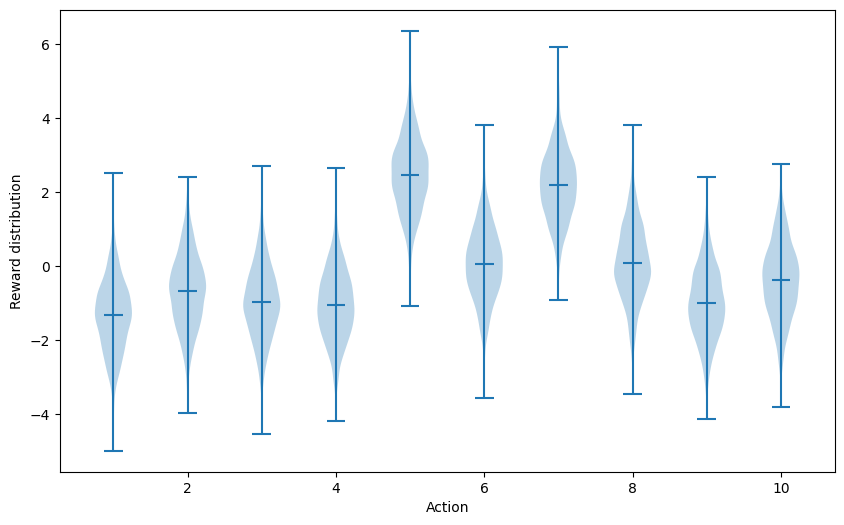

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.violinplot(np.random.randn(2000, 10) + env.means, showmeans=True)
plt.xlabel("Action")
plt.ylabel("Reward distribution")

plt.show()

If we knew the value of each action, then it would be trivial to solve the  problem: we always select the action with highest value: 

$\displaystyle a_* = \underset{a}{\text{argmax }}q(a)$

However, we assume to not know the action values with certainty, although we may have estimates.

## Estimation of the action value

Notice that the estimation of the action-value function in MAB environments is pretty straightforward. Because MABs are one-step environments, to estimate the value of an action, we need to calculate the average reward obtained by selecting that action. In other words, the estimate of an action value is equal to the total reward obtained when selecting the action, divided by the number of times action a has been selected:

$\displaystyle q_t(a) = \frac{\sum\limits_{i=1}^{t-1}{R_i\cdot 1_{A_i=a}} }{\sum\limits_{i=1}^{t-1}{1_{A_i=a}} } $

We call this estimation the **sample-average method**, because each estimate is an average of the sample of relevant rewards.

The obvious implementation would be to maintain a record of all the rewards and then perform the computation whenever the estimated value was needed. However,the memory and computational requirements would grow over time as more rewards are seen. Each additional reward would require additional memory to store it and additional computation to compute the sum in the numerator.

This is not really necessary. It is easy to devise **incremental formulas** for updating averages with small, constant computation required to process each new reward. To simplify notation, we concentrate on a single action:

$\displaystyle q_{n+1}=\frac{R_1+R_2+...+R_n}{n}=\frac{1}{n}\sum\limits_{i=1}^{n}{R_i} = \frac{1}{n}\left(R_n+\sum\limits_{i=1}^{n-1}{R_i}\right)=\frac{1}{n}\left(R_n+(n-1)\frac{1}{n-1}\sum\limits_{i=1}^{n-1}{R_i}\right)= $

$\displaystyle = \frac{1}{n}\left(R_n+(n-1)q_n\right)=\frac{1}{n}\left(R_n+nq_n-q_n\right)= q_n+\frac{1}{n}(R_n-q_n) $

This implementation requires memory only for $q_n$ and $n$, and only a small computation for each new reward. This update is of a form of the general rule:

**NewEstimate <-- OldEstimate + StepSize (Target - OldEstimate)**

The expression "Target−OldEstimate" is an error in the estimate, and it is reduced by taking a step toward the "Target", which is presumed to indicate a desirable direction in which to move, though it may be noisy. 

In our case above, for example, the target is the reward and the step-size parameter changes from time step to time step, in processing the n reward for action a, the method uses the step-size 1/n.

The averaging method is appropriate for **stationary** bandit problems, in which the reward probabilities do not change over time. However, we often encounter problems that are **non-stationary**. In such cases, it makes sense to give more weight to recent rewards than to long-past rewards.  One of the most popular ways of doing this is to use a constant step-size parameter:

$\displaystyle q_{n+1}=q_n+\alpha(R_n-q_n) $

where the step-size parameter $\alpha \in (0, 1]$ is constant. This results in $q_n$ being a weighted average of past rewards and the initial estimate $q_1$:

$\displaystyle q_{n+1}=q_n+\alpha(R_n-q_n)=\alpha R_n + (1-\alpha)q_n = $

$\displaystyle =\alpha R_n + (1-\alpha)(\alpha R_{n-1}+(1-\alpha)q_{n-1})= $

$\displaystyle =\alpha R_n + (1-\alpha)\alpha R_{n-1}+(1-\alpha)^2q_{n-1}= $

$\displaystyle =\alpha R_n + (1-\alpha)\alpha R_{n-1}+(1-\alpha)^2 R_{n-2} + ... + (1-\alpha)^{n-1} \alpha R_1 + (1-\alpha)^n q_1 $

$\displaystyle =(1-\alpha)^n q_1 + \sum\limits_{i=1}^{n}{\alpha(1-\alpha)^{n-1}R_i} $

Sometimes it is convenient to vary the step-size parameter from step to step. Let $\alpha_n(a)$ denote the step-size parameter used to process the reward received after the $n_{th}$ selection of action $a$. In that case the weighting on each prior reward is:

$\displaystyle q_{n+1}=q_n+\alpha_n(R_n-q_n)=\alpha_n R_n + (1-\alpha_n)q_n = $

$\displaystyle =\alpha_n R_n + (1-\alpha_n)(\alpha_{n-1} R_{n-1}+(1-\alpha_{n-1})q_{n-1})= $

$\displaystyle =\alpha_n R_n + (1-\alpha_n)\alpha_{n-1} R_{n-1}+(1-\alpha_n)(1-\alpha_{n-1})q_{n-1}= $

$\displaystyle =\alpha_n R_n + (1-\alpha_n)\alpha_{n-1} R_{n-1}+(1-\alpha_n)(1-\alpha_{n-1})\alpha_{n-2} R_{n-2} + ... + (1-\alpha_n)(1-\alpha_{n-1})...(1-\alpha_1)q_1= $

$\displaystyle =\prod\limits_{i=1}^{n}{(1-\alpha_i)}q_1+\sum\limits_{i=1}^{n}{\alpha_i\prod\limits_{j=i+1}^{n}{(1-\alpha_j)R_i} } $

The choice $\alpha_n(a)=1/n$ results in the sample-average method, which is guaranteed to converge to the true action values by the law of large numbers. But of course convergence is not guaranteed for all choices of $\alpha_n(a)$. A
result in stochastic approximation theory gives us the **conditions required to
assure convergence**:

$\displaystyle
\sum\limits_{n=1}^{\infty }{\alpha_n(a)}=\infty \hspace{30 pt} \sum\limits_{n=1}^{\infty }{\alpha_n^2(a)}<\infty $

The first condition is required to guarantee that the **steps are large enough** to eventually overcome any initial conditions or random fluctuations. The second condition guarantees that eventually the **steps become small enough** to assure convergence. Note that both convergence conditions are met for the sample-average case,  but not for the case of constant step-size parameter. In the latter case, the second condition is not met, indicating that the estimates never completely converge but continue to vary in response to the most recently received rewards. **This is actually desirable in a non-stationary environment**.

All the methods we have discussed so far are biased (dependent to some extent) by their initial estimates $q_1(a)$. For the sample-average methods, the bias disappears once all actions have been selected at least once, but for methods with constant $\alpha$, the bias is permanent, though decreasing over time. In practice, this kind of bias is usually not a problem and can sometimes be very helpful to supply some **prior knowledge** about what level of rewards can be expected. 

It’s essential to highlight that there are no differences in how strategies estimate the action-value function, the only difference is in how each strategy uses the estimates to select actions.

## Basic exploration strategies

If we maintain the estimates of the action values, then at any time step there is at least one action whose estimated value is greatest. We call this the **greedy action**.  When we select this action, we say that we are **exploiting our current knowledge** of the values of the actions. If there is more than one greedy action, then a selection is made among them in some arbitrary way, perhaps randomly.

$\displaystyle A_t=\underset{a}{\text{argmax }}q_t(a)$

Greedy action selection always **exploits** current knowledge **to maximize immediate reward**, it spends no time at all sampling apparently inferior actions to see if they might really be better. 

Instead, if we select one of the non-greedy actions, then we say we are **exploring**, because this enables to improve the estimate of the non-greedy action’s value. 

**Exploitation is the right thing to do to maximize the expected reward on the one step, but exploration may produce the greater total reward in the long run**. 

Unfortunately, it is not possible both to explore and to exploit with any single action selection, one often refers to the **conflict between exploration and exploitation**. The need to balance exploration and exploitation is a distinctive challenge that arises in reinforcement learning.

Notice the relationship between a greedy strategy and time. If the agent only has one episode left, the best thing is to act greedily (if you know you only have one day to live, you’ll do things you enjoy the most): this is a reasonable thing to do when we have limited time left. However, if we don’t, we can trade-off immediate satisfaction for gaining of information that would allow us better long-term results.

Notice also that while there’s only a single way to exploit, there are **multiple ways to explore**. Exploiting is nothing but doing what you think is best, exploring, on the other hand, is much more complex. It’s obvious you need to collect information, but how is a different question. We could try gathering information to support your current beliefs. We could gather information to attempt proving ourself wrong. We could explore based on confidence, or based on uncertainty. The list goes on...

### Pure exploration and pure exploitation

The **greedy strategy** (always exployt) and the **pure random strategy** (always explore) aren't really streategies, but two important baselines. 

In [3]:
def pure_exploitation(env, n_episodes=1000):
    
    # initialize the Q-function and the count array to all zeros
    Q = np.zeros((env.size), dtype=float)
    N = np.zeros((env.size), dtype=int)

    # some variables to calculate statistics and not necessary
    Qe = np.empty((n_episodes, env.size), dtype=float)
    returns = np.empty(n_episodes, dtype=float)
    actions = np.empty(n_episodes, dtype=int)
    
    # here we enter the main loop and interact with the environment
    for e in range(n_episodes):
        
        # select the action that maximizes the estimated Q-values
        action = np.argmax(Q)

        # then, pass it to the environment and receive a new reward
        reward = env.step(action)
        
        # update the counts and the Q-table
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        # update the statistics and start a new episode
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
        
    return returns, Qe, actions

In [4]:
def pure_exploration(env, n_episodes=1000):
    
    # The baseline boilerplate is the same as before
    Q = np.zeros((env.size), dtype=float)
    N = np.zeros((env.size), dtype=int)

    Qe = np.empty((n_episodes, env.size), dtype=float)
    returns = np.empty(n_episodes, dtype=float)
    actions = np.empty(n_episodes, dtype=int)

    for e in range(n_episodes):
        
        # always selects an action randomly
        action = np.random.randint(len(Q))
        
        reward = env.step(action)
        
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
        
    return returns, Qe, actions

### Epsilon greedy

We combine the two baselines, pure exploitation and pure exploration, so that the agent can exploit, but also collect information to make informed decisions. The **hybrid strategy** consists of **acting greedily most of the time and exploring randomly every so often**. This strategy is referred as the **epsilon-greedy strategy**.

<img src="./images/epsilon-greedy.png" width="500">

In [5]:
def epsilon_greedy(env, epsilon=0.01, n_episodes=1000):
    
    # The baseline boilerplate is the same as before
    Q = np.zeros((env.size), dtype=float)
    N = np.zeros((env.size), dtype=int)

    Qe = np.empty((n_episodes, env.size), dtype=float)
    returns = np.empty(n_episodes, dtype=float)
    actions = np.empty(n_episodes, dtype=int)
    
    for e in range(n_episodes):
        
        # draw a random number and compare to a hyperparameter epsilon
        if np.random.uniform() > epsilon:
            # if it is greater than epsilon, exploit:
            action = np.argmax(Q)
        else:
            # otherwise, explore:
            action = np.random.randint(len(Q))

        reward = env.step(action)
        
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return returns, Qe, actions

We can measure the performance and the behavior of the method over 1000 time steps when applied to a simulation of the 10-armed bandit problem. Repeating this for 2000 independent runs, each with a different bandit problem, we obtain a measure of the learning algorithm’s average behavior. The following code compares methods with different values of epsilon:

In [6]:
from tqdm import tqdm

returns_exploitation = [];  # pure exploitation
returns_epsilon_01 = [];    # epsilon=0.1
returns_epsilon_001 = [];   # epsilon=0.01
returns_exploration = [];   # pure exploration

repetitions = 2000

envs = []
for i in range(repetitions):
    envs.append(BanditEnv());

for i in tqdm(range(repetitions), desc='Running pure exploitation'):
    returns, _, _ = pure_exploitation(env=envs[i], n_episodes=1000);
    returns_exploitation.append(returns);

for i in tqdm(range(repetitions), desc='Running epsilon greedy 0.1'):
    returns, _, _ = epsilon_greedy(env=envs[i], epsilon=0.1);
    returns_epsilon_01.append(returns); 

for i in tqdm(range(repetitions), desc='Running epsilon greedy 0.01'):
    returns, _, _ = epsilon_greedy(env=envs[i], epsilon=0.01);
    returns_epsilon_001.append(returns);

for i in tqdm(range(repetitions), desc='Running pure exploration'):
    returns, _, _ = pure_exploration(env=envs[i]); 
    returns_exploration.append(returns);
    
returns_exploitation = np.array(returns_exploitation);
returns_epsilon_01 = np.array(returns_epsilon_01);
returns_epsilon_001 = np.array(returns_epsilon_001);
returns_exploration = np.array(returns_exploration);

Running pure exploration: 100%|██████████| 2000/2000 [00:04<00:00, 400.94it/s]


In [7]:
# Average reward
avg_reward_exploitation = np.average(returns_exploitation, axis=0)
avg_reward_epsilon_01 = np.average(returns_epsilon_01, axis=0)
avg_reward_epsilon_001 = np.average(returns_epsilon_001, axis=0)
avg_reward_exploration = np.average(returns_exploration, axis=0)

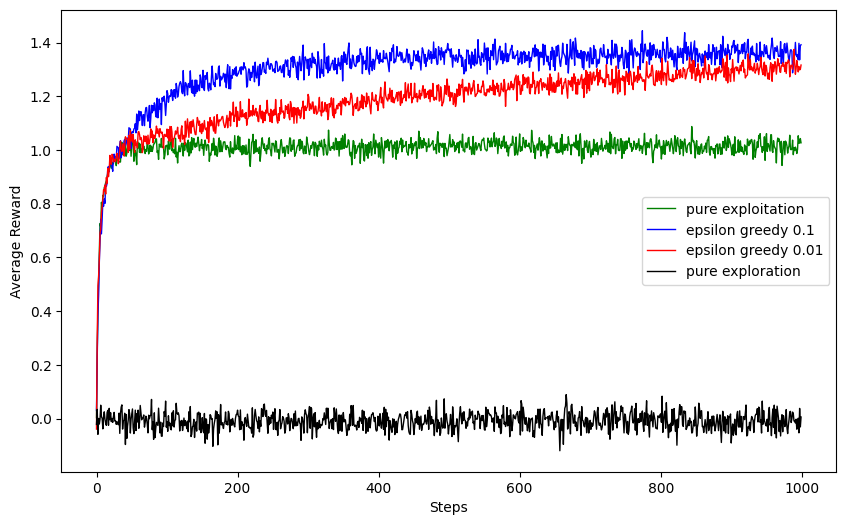

In [8]:
plt.figure(figsize=(10,6))

plt.plot(avg_reward_exploitation,linewidth=1, color='green', label='pure exploitation')
plt.plot(avg_reward_epsilon_01,  linewidth=1, color='blue',  label='epsilon greedy 0.1')
plt.plot(avg_reward_epsilon_001, linewidth=1, color='red',   label='epsilon greedy 0.01')
plt.plot(avg_reward_exploration, linewidth=1, color='black', label='pure exploration')
plt.xlabel('Steps');
plt.ylabel('Average Reward')
plt.legend()

plt.show()

The pure exploitation method improved slightly faster than the others at the very beginning, but it performs significantly worse in the long run because it got stuck performing suboptimal actions. 

The greedy methods performs better because they continued to explore and to improve their chances of recognizing the optimal action:

- epsilon=0.1 explored more, and usually found the optimal action earlier, but it never selected that action more than 91% of the time, because it explores 10% of the time;

- epsilon=0.01 method improved more slowly (it explores less), but eventually would perform better in the long run, because it explore only 1% of time. 

It is possible to reduce epsilon over time to try to get the best of both high and low values.

We can plot Q value in order to check if they are estimated correctly:

In [9]:
_, Q, _ = epsilon_greedy(env=env, epsilon=0.5, n_episodes=10000)

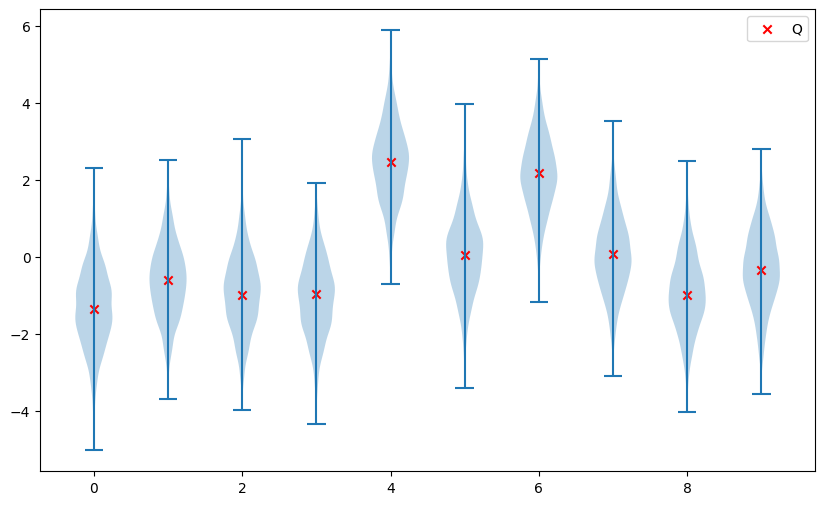

In [10]:
plt.figure(figsize=(10,6))
plt.violinplot(np.random.randn(2000, 10) + env.means, positions=range(env.size))
plt.scatter(range(env.size), Q[9999], color='red', marker='x', label='Q')
plt.legend();

### Decaying epsilon-greedy

Intuitively, **early on we can explore the most** (when the agent hasn’t experienced the environment enough), **later we want the agent to exploit more and more** (as it obtains better estimates of the value functions). In the decaying method we start with a high epsilon and the we decay its value on every step. This strategy can take many forms depending on **how we change the value of epsilon** (linearly or exponentially). The following is an exponential implementation:

Notice that we can calculate all of the epsilon values at once, and only query an array of pre-computed values in the loop

In [12]:
def decay_epsilon(init_value, min_value, decay_episodes, max_episodes):

    # calculate the number of the remaining episodes after the decay
    rem_episodes = max_episodes - decay_episodes
    
    # logspace returns numbers spaced evenly on a log scale
    # base^start is the starting value of the sequence,
    # base^stop is the final value of the sequence
    # num is the number of values to generate
    # base is the base of the log space
    values = np.logspace(start=0, stop=-2, num=decay_episodes, base=10)
    
    # because the values may not end exactly at 0, given it’s the log, 
    # we change them to be between 0 and 1 so that the curve looks smooth and nice.
    values = (values - values.min()) / (values.max() - values.min())
    
    # linear transformation and get points between init_value and min_value
    values = (init_value - min_value) * values + min_value
    
    # repeats the rightmost value rem_step number of times
    values = np.pad(values, (0, rem_episodes), 'edge')
    
    return values

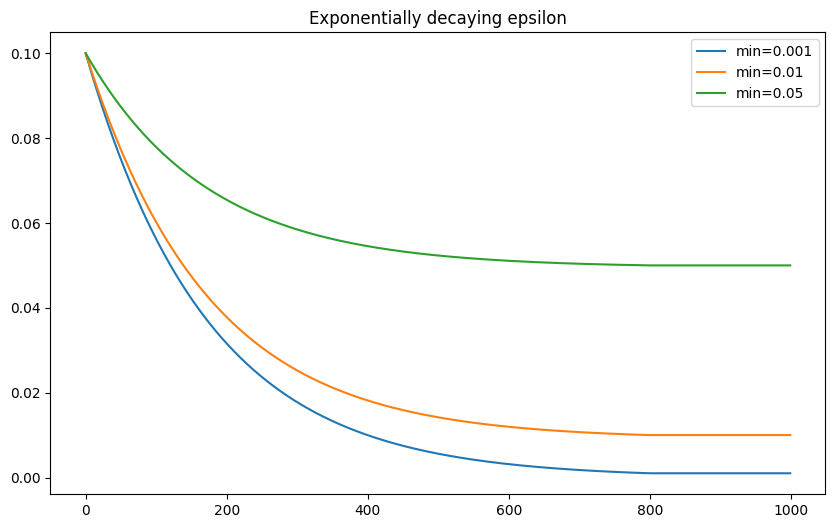

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(decay_epsilon(0.1, 0.001, 800, 1000), label='min=0.001')
plt.plot(decay_epsilon(0.1, 0.01, 800, 1000), label='min=0.01')
plt.plot(decay_epsilon(0.1, 0.05, 800, 1000), label='min=0.05')
plt.title('Exponentially decaying epsilon')
plt.legend()

plt.show()

In [44]:
def decay_epsilon_greedy(env, init_epsilon=1, min_epsilon=0.001, decay_episodes=100, n_episodes=1000):
    
    # The baseline boilerplate is the same as before
    Q = np.zeros((env.size), dtype=float)
    N = np.zeros((env.size), dtype=int)

    Qe = np.empty((n_episodes, env.size), dtype=float)
    returns = np.empty(n_episodes, dtype=float)
    actions = np.empty(n_episodes, dtype=int)
    
    # Calculate the exponentially decaying epsilons. 
    epsilons = decay_epsilon(init_epsilon, min_epsilon, decay_episodes, n_episodes);
    
    for e in range(n_episodes):
        
        if np.random.uniform() > epsilons[e]:
            action = np.argmax(Q)
        else:
            action = np.random.randint(len(Q))

        reward = env.step(action)
        
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    
    return returns, Qe, actions

In [45]:
returns_epsilon_decay = [];

for i in tqdm(range(repetitions), desc='Running epsilon decay'):
    returns, _, _ = decay_epsilon_greedy(env=envs[i]);
    returns_epsilon_decay.append(returns); 
    
returns_epsilon_decay = np.array(returns_epsilon_decay);

Running epsilon decay: 100%|██████████| 2000/2000 [00:06<00:00, 312.80it/s]


In [46]:
# Average reward
avg_reward_epsilon_decay = np.average(returns_epsilon_decay, axis=0);

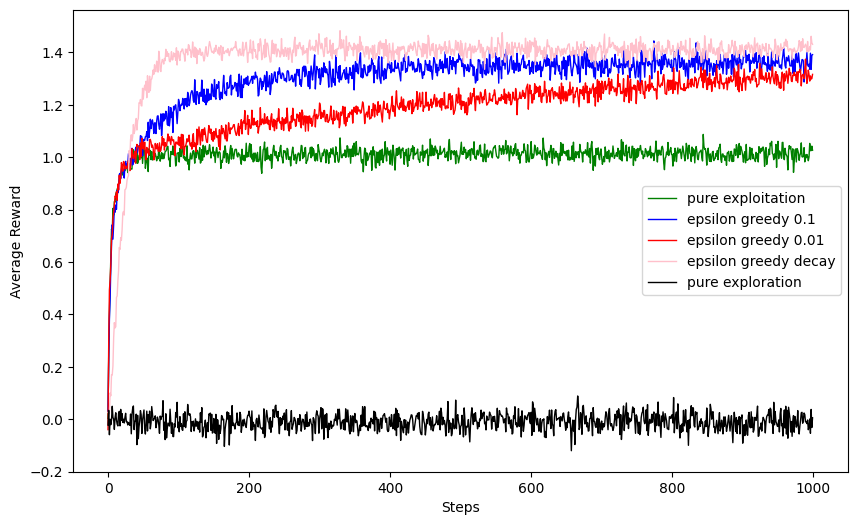

In [47]:
plt.figure(figsize=(10,6))

plt.plot(avg_reward_exploitation,   linewidth=1, color='green', label='pure exploitation')
plt.plot(avg_reward_epsilon_01,  linewidth=1, color='blue',  label='epsilon greedy 0.1')
plt.plot(avg_reward_epsilon_001, linewidth=1, color='red',   label='epsilon greedy 0.01')
plt.plot(avg_reward_epsilon_decay, linewidth=1, color='pink',   label='epsilon greedy decay')
plt.plot(avg_reward_exploration, linewidth=1, color='black',   label='pure exploration')
plt.xlabel('Steps');
plt.ylabel('Average Reward')
plt.legend()


plt.show()

There are many other ways we can handle the decaying of epsilon. The bottom line is that **the agent should explore with a higher chance early and exploit with a higher chance later**. Early on, there’s a high likelihood that value estimates are wrong. Still, as time passes and he acquires knowledge, the likelihood that the value estimates are close to the actual values increases, which is when the agent should explore less frequently so that he can exploit the knowledge acquired.

### Optimistic initial values

Initial action values can be used as a simple way to **encourage exploration**. Suppose to set an initial estimate in a **optimistic way**. Whichever actions are initially selected, the reward is less than the starting estimates and the learner switches to other actions, being **"disappointed"** with the rewards it is receiving. The result is that **all actions are tried several times** before the value estimates converge. The system does a fair amount of exploration even if greedy actions are selected all the time. We call this technique for encouraging exploration **optimistic initial values**. 

The mechanic of the strategy is straightforward: we initialize the action-value function to a high value and act greedily using these estimates.

In [48]:
def optimistic_initialization(env, optimistic_estimate=5.0, initial_count=10, n_episodes=1000):
    
    # start initializing the Q-values to an optimistic value
    Q = np.full((env.size), optimistic_estimate, dtype=float)
    
    # initialize the counts that will serve as an uncertainty measure
    # the higher the more certain.
    N = np.full((env.size), initial_count, dtype=int)
    
    Qe = np.empty((n_episodes, env.size), dtype=float)
    returns = np.empty(n_episodes, dtype=float)
    actions = np.empty(n_episodes, dtype=int)

    for e in range(n_episodes):
        
        action = np.argmax(Q)

        reward = env.step(action)
        
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]

        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
        
    return returns, Qe, actions

In [49]:
returns_optimistic = [];

for i in tqdm(range(repetitions), desc='Running optmistic method'):
    returns, _, _ = optimistic_initialization(env=envs[i]) 
    returns_optimistic.append(returns); 
    
returns_optimistic = np.array(returns_optimistic)

Running optmistic method: 100%|██████████| 2000/2000 [00:04<00:00, 473.45it/s]


In [50]:
# Average reward
avg_reward_optimistic = np.average(returns_optimistic, axis=0)

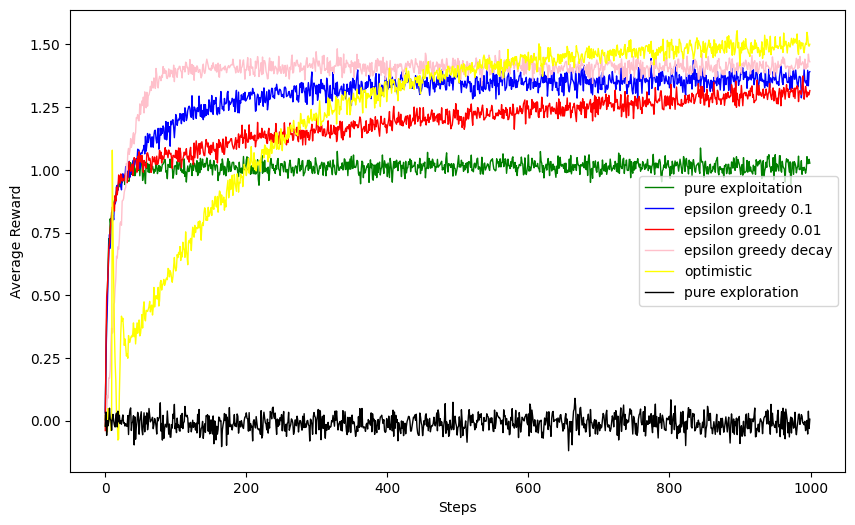

In [51]:
plt.figure(figsize=(10,6))

plt.plot(avg_reward_exploitation,   linewidth=1, color='green', label='pure exploitation')
plt.plot(avg_reward_epsilon_01,  linewidth=1, color='blue',  label='epsilon greedy 0.1')
plt.plot(avg_reward_epsilon_001, linewidth=1, color='red',   label='epsilon greedy 0.01')
plt.plot(avg_reward_epsilon_decay, linewidth=1, color='pink',   label='epsilon greedy decay')
plt.plot(avg_reward_optimistic, linewidth=1, color='yellow',   label='optimistic')
plt.plot(avg_reward_exploration, linewidth=1, color='black',   label='pure exploration')
plt.xlabel('Steps');
plt.ylabel('Average Reward')
plt.legend()

plt.show()

Initially, the optimistic method performs worse because it explores more. In the early part of the curve for the optimistic method we can see **oscillations and spikes**. If the initial action selected are by chance ones of the better choices then the action value estimates for these plays will be magnified resulting in an emphasis to continue playing this action. This results in large actions values being received on the initial draws and consequently very good initial play. In the same way, if the algorithm initially selects poor plays then initially the algorithm will perform poorly resulting in very poor initial play.

We regard it as a **simple trick** that can be **quite effective on stationary problems**, but it is not well suited to non-stationary problems because its drive for exploration is inherently temporary.

## Strategic Exploration

While humans explore, they don’t explore randomly. Maybe imprecision is the source of randomness, but humans have a **strategic way of exploring**. We know that we’re sacrificing short-term for long-term satisfaction. **We know we want to acquire more information**. We explore by trying things **we haven’t sufficiently tried** but **have the potential to better our lives**. Perhaps, our exploration strategies are a combination of estimates and their uncertainty. 

For instance, we might prefer a dish that we’re likely to enjoy, and we haven’t tried, over a dish that we like okay, but we get every weekend. Perhaps we explore **based on our curiosity or our prediction error**. For instance, we might be more inclined to try new dishes at a restaurant that we thought would be okay-tasting food, but it resulted in the best food you ever had. That **prediction error** and that **surprise** could be our metric for exploration.

We can consider more advanced exploration strategies that apply randomness in proportion to the current estimates of the actions or that take into account the confidence and uncertainty levels of the estimates.

The epsilon-greedy strategy (and its decaying versions) is still the most popular exploration strategy in use today, perhaps because it per forms well, perhaps because of its simplicity. 

Balancing the exploration versus exploitation trade-off, the gathering and utilization of information is central to human intelligence, artificial intelligence, and reinforcement learning.

### Softmax method

Random exploration makes more sense if it takes into account action-value estimates: **if there is an action that has a really low estimate, we’re less likely to try it**. The Softmax strategy **samples actions from a probability distribution over the action-value estimates**, such that the probability of selecting an action is proportional to its current action-value estimate. The difference between estimates will create a tendency to select actions with the highest estimates more often, and actions with the lowest estimates less frequently. 

We can also add a **hyperparameter to control the algorithm’s sensitivity** to the differences in estimates. That hyperparameter, called the **temperature**, works in such a way that as it approaches infinity, the preferences over the action-values are equal (it samples uniformly); but, as it approaches zero, the action with the highest estimated value will be sampled with probability of one. Also, we can decay this hyperparameter either linearly, exponentially, or another way.

$\displaystyle \text{Pr}(a)= \frac{ e^{\frac{q(a)}{\tau}}}{\sum\limits_{b=1}^{B}{e^{\frac{q(b)}{\tau}}} } $

In [43]:
def softmax(env, init_temp=1000, min_temp=0.1,
            decay_ratio=0.04,n_episodes=1000):
    
    Q = np.zeros((env.size), dtype=float)
    N = np.zeros((env.size), dtype=int)

    Qe = np.empty((n_episodes, env.size), dtype=float)
    returns = np.empty(n_episodes, dtype=float)
    actions = np.empty(n_episodes, dtype=int)
    
    for e in range(n_episodes):
        
        # calculate the linearly decaying temperature 
        decay_episodes = n_episodes * decay_ratio
        temp = 1 - e / decay_episodes
        temp *= init_temp - min_temp
        temp += min_temp
        temp = np.clip(temp, min_temp, init_temp)

        # calculate the probabilities by applying the softmax function 
        # to the estimates
        scaled_Q = Q / temp
        norm_Q = scaled_Q - np.max(scaled_Q)
        exp_Q = np.exp(norm_Q)
        probs = exp_Q / np.sum(exp_Q)
    
        # select the action based on probabilities
        action = np.random.choice(np.arange(len(probs)), size=1, p=probs)[0]

        reward = env.step(action)
        
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    
    return returns, Qe, actions

### Upper Confidence Bound method

The optimistic initialization strategy is a clever and efficient approach, however, it has two significant inconveniences. First, **we don’t know the maximum reward the agent can obtain**. If we set the initial optimistic estimates to a value much higher than its actual value, the algorithm will perform sub-optimally for a long time, because the agent will take many episodes to bring the estimates near the actual values. Even worse, if we set the initial values lower than the maximum, the algorithm will no longer be optimistic, and it will no longer work. The second issue is that **the counts variable is a hyperparameter and it needs tuning**, but what we’re trying to represent with this variable **is the uncertainty of the estimate**, which shouldn’t be a hyperparameter. 

A better strategy, that follows the same principles of optimistic initialization, is the **upper confidence bound (UCB)** which use statistical techniques to calculate the value estimates uncertainty and uses that as a bonus for exploration.  In UCB, we’re still optimistic, but it’s **a more a realistic optimism**. Instead of blindly hoping for the best, we look at the uncertainty of value estimates. **The more uncertain an estimate, the more critical it is to explore it**. Notice that it’s no longer about believing the value will be the “maximum possible”, though it might be! The new metric that we care about here is uncertainty; we want **to give uncertainty the benefit of the doubt**.

To select the action at episode we add the estimates and an uncertainty bonus:

$\displaystyle A_t=\underset{a}{\text{argmax}} \left[q_t(a)+c\sqrt{\left[\frac{\ln t}{N_t(a)} \right] } \right] $ 

The idea is that **the square-root term is a measure of the uncertainty** in the estimate of the action value. Each time an action $a$ is selected the uncertainty is presumably reduced ($N_t(a)$ increments and the uncertainty term decreases). On the other hand, each time an action other than $a$ is selected, $t$ increases but $N_t(a)$ does not and the uncertainty estimate increases. The use of the logarithm means that the increases get smaller over time, but are unbounded. All actions will eventually be selected, but actions with lower value estimates, or that have already been selected frequently, will be selected with decreasing frequency over time. UCB often performs well but is more difficult than epsilon-greedy to extend beyond bandits to the more general reinforcement learning settings.

In [44]:
def upper_confidence_bound(env, c=2, n_episodes=1000):
    
    Q = np.zeros((env.size), dtype=float)
    N = np.zeros((env.size), dtype=int)
    
    Qe = np.empty((n_episodes, env.size), dtype=float)
    returns = np.empty(n_episodes, dtype=float)
    actions = np.empty(n_episodes, dtype=int)

    for e in range(n_episodes):
        # first select all actions once to avoid division by zero
        if e < len(Q):
            action = e    
        else: 
            # proceed to calculating the confidence bounds
            U = np.sqrt(c * np.log(e)/N)
            # pick the action with the highest value with an 
            # uncertainty bonus: the more uncertain the value of the action, 
            # the higher the bonus
            action = np.argmax(Q + U)

        reward = env.step(action)
        
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
        
    return returns, Qe, actions

In [49]:
returns_softmax = [];
returns_ucb = [];

for i in tqdm(range(repetitions), desc='Running softmax method'):
    returns, _, _ = softmax(env=envs[i]);
    returns_softmax.append(returns);
    
for i in tqdm(range(repetitions), desc='Running ucb method'):
    returns, _, _ = upper_confidence_bound(env=envs[i]);
    returns_ucb.append(returns); 
    
returns_softmax = np.array(returns_softmax);
returns_ucb = np.array(returns_ucb);

Running ucb method: 100%|██████████| 2000/2000 [00:08<00:00, 231.14it/s]


In [50]:
# Average reward
avg_reward_softmax = np.average(returns_softmax, axis=0)
avg_reward_ucb = np.average(returns_ucb, axis=0)

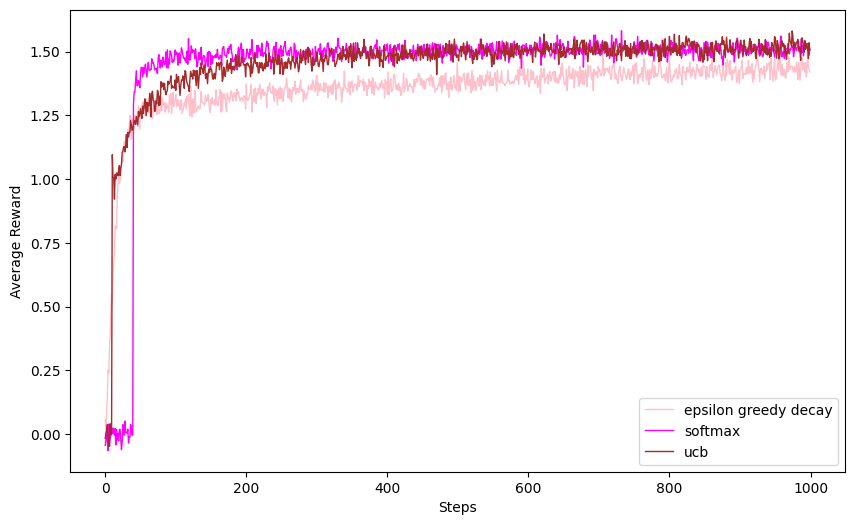

In [51]:
plt.figure(figsize=(10,6))

plt.plot(avg_reward_epsilon_decay, linewidth=1, color='pink',   label='epsilon greedy decay')
plt.plot(avg_reward_softmax, linewidth=1, color='magenta',   label='softmax')
plt.plot(avg_reward_ucb, linewidth=1, color='brown',   label='ucb')
plt.xlabel('Steps');
plt.ylabel('Average Reward')
plt.legend()

plt.show()

## Comparison

We have presented several simple ways of balancing exploration and exploitation. The epsilon-greedy methods choose randomly a small fraction of the time, UCB methods choose deterministically but achieve exploration by subtly favoring at each step the actions that have so far received fewer samples. 

We can run simulations for all methods in order to compare their performances. A complication is that they all have a parameter. To get a meaningful comparison we have to consider their performance as a function of their parameter. We summarize a complete learning curve by its average value over the 1000 steps and shows this measure for the various bandit algorithms, each as a function of its own parameter shown on a single scale on the x-axis. This kind of graph is called a **parameter study**. 

In [74]:
def run_experiment(envs, algorithm, param):    
    returns = [];

    desc = 'Running ' + algorithm + ' with parameter ' + str(param);

    for i in tqdm(range(2000), desc=desc):

        if algorithm == 'epsilon-greedy':
            r, _, _ = epsilon_greedy(env, epsilon=param, n_episodes=1000);
        elif algorithm == 'optimistic-initialization':
            r,_ ,_ = optimistic_initialization(env, optimistic_estimate=param, initial_count=10, n_episodes=1000);
        elif algorithm == 'softmax':
            r,_ ,_ = softmax(env, init_temp=param, min_temp=0.1, decay_ratio=0.04,n_episodes=1000);
        elif algorithm == 'ucb':
            r,_ ,_ = upper_confidence_bound(env, c=param, n_episodes=1000);
        else:
            raise ValueError('Unknown algorithm:', algorithm)
        
        returns.append(r);
    
    returns = np.array(returns);
    return returns.mean()

In [72]:
egreedy_x, egreedy_y = [], []
for param in [1/128, 1/64, 1/32, 1/16, 1/8, 1/4]:
    result = run_experiment(envs=envs, algorithm='epsilon-greedy', param=param);
    egreedy_x.append(param)
    egreedy_y.append(result)

Running epsilon-greedy with parameter 0.25: 100%|██████████| 2000/2000 [00:06<00:00, 309.71it/s]


In [80]:
opt_x, opt_y = [], []
for param in [1/4, 1/2, 1, 2, 4, 6]:
    result = run_experiment(envs=envs, algorithm='optimistic-initialization', param=param)
    opt_x.append(param)
    opt_y.append(result)

Running optimistic-initialization with parameter 0.25: 100%|██████████| 2000/2000 [00:04<00:00, 489.25it/s]
Running optimistic-initialization with parameter 0.5: 100%|██████████| 2000/2000 [00:04<00:00, 483.11it/s]
Running optimistic-initialization with parameter 1: 100%|██████████| 2000/2000 [00:04<00:00, 484.09it/s]
Running optimistic-initialization with parameter 2: 100%|██████████| 2000/2000 [00:04<00:00, 481.49it/s]
Running optimistic-initialization with parameter 4: 100%|██████████| 2000/2000 [00:04<00:00, 482.29it/s]
Running optimistic-initialization with parameter 6: 100%|██████████| 2000/2000 [00:04<00:00, 479.60it/s]


In [92]:
ucb_x, ucb_y = [], []
for param in [1/16, 1/8, 1/4, 1/2, 1, 2, 4]:
    result = run_experiment(envs=envs, algorithm='ucb', param=param)
    ucb_x.append(param)
    ucb_y.append(result)

Running ucb with parameter 4: 100%|██████████| 2000/2000 [00:07<00:00, 266.39it/s]


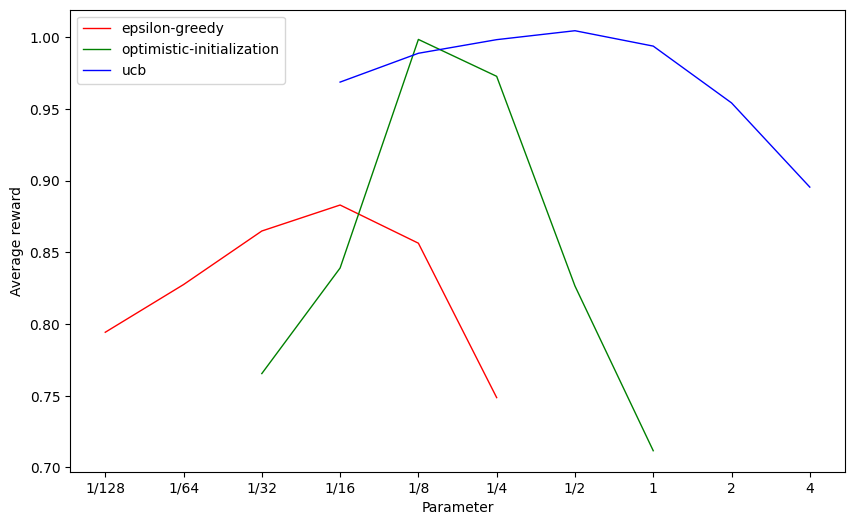

In [108]:
plt.figure(figsize=(10,6))

plt.xticks(range(-7, 3), ('1/128', '1/64', '1/32', '1/16', '1/8', '1/4', '1/2', '1', '2', '4'))
plt.plot(range(-7, -1), egreedy_y, linewidth=1, color='red', label='epsilon-greedy')
plt.plot(range(-5, 1), opt_y, linewidth=1, color='green', label='optimistic-initialization')
plt.plot(range(-4, 3), ucb_y, linewidth=1, color='blue', label='ucb')

plt.xlabel('Parameter')
plt.ylabel('Average reward')
plt.legend()

plt.show()

Overall, on this problem, **UCB seems to perform best**. Notice the characteristic **inverted-U shapes** of each algorithm’s performance: all the algorithms perform best at an **intermediate value of their parameter**, neither too large nor too small. In assessing a method, we should attend not just to how well it does at its best parameter setting, but also to **how sensitive it is to its parameter value**. All of these algorithms are fairly insensitive, performing well over a range of parameter values varying by about an order of magnitude. 